In [ ]:
!pip install stable-baselines==2.9.0

In [ ]:
import numpy as np

import datetime
import time
from collections import deque

import torch as T
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.distributions import Categorical
from torch.optim.lr_scheduler import LambdaLR
from torchsummary import summary

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
ENV_NAME = 'BreakoutNoFrameskip-v4'
NENV = 8
ROLLOUT_LENGTH = 128
LATENT_SIZE = 256
MB_SPLIT = 4
MB_EPOCHS = 4
TOTAL_TIMESTEPS = 5e6
GAMMA = 0.99
CLIP = 0.2
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
SEED = 420 
set_global_seeds(SEED)
sns.set()  # make it pretty

# Environment

In [6]:
env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
env = VecFrameStack(env, n_stack=4)

in_dim = env.observation_space.shape
in_dim=(in_dim[2],in_dim[0],in_dim[1])  # torch ordering
num_actions = env.action_space.n

print('Observation shape: ', in_dim)
print('Number of actions: ', num_actions)

Observation shape:  (4, 84, 84)
Number of actions:  4


# CNNs

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
class AutoEncoder(nn.Module):
    """ This is used to *represent* the environment (perception).
        The latent space of this autoencoder is uni-dimensional.
    """
    def __init__(self, input_shape, num_actions, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.num_actions = num_actions
        self.latent_size = latent_size
        
        self.encoder_conv = nn.Sequential(
        nn.Conv2d(self.c, 64, 8, 4),
        nn.ReLU(True),
        nn.Conv2d(64, 32, 4, 2),
        nn.ReLU(True),
        nn.Conv2d(32, 16, 4, 1),
        nn.ReLU(True)
        )

        self.conv_x, self.conv_f = conv_size(self.encoder_conv, input_shape)

        self.encoder_linear = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(self.conv_f, self.latent_size)
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(self.latent_size, self.conv_f),
            nn.ReLU(True)
        )

        self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(16+self.num_actions, 32, 4, 1),  # note num_actions
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 64, 4, 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, self.c, 8, 4)
        )

    def encode(self, x):
        """ *represent* the environment in latent space"""
        x = self.encoder_conv(x)
        x = self.encoder_linear(x)
        return x  # latent code

    def one_hot_3d_action(self, actions):
        _,_,ch,cw = self.conv_x
        cn = len(actions)
        z = np.zeros((len(actions), self.num_actions, ch, cw), dtype=np.float32)
        for i in range(cn):
            z[i,actions[i],:,:] = 1.0
        z = T.from_numpy(z).to(DEVICE)
        return z

    def forward(self, x, actions=None):
        """ actions is a list of ints describing the actions taken """
        x = self.encoder_conv(x)
        latent = self.encoder_linear(x)
        x = self.decoder_linear(latent)
        x = x.view(self.conv_x)
        # add information about which action we took
        if actions is None:  # for torchsummary
            z_action = self.one_hot_3d_action([0]*x.size(0))
        else:
            z_action = self.one_hot_3d_action(actions)
        x = T.cat((x, z_action), dim=1)
        x = self.decoder_conv(x)
        return x, latent

In [0]:
class ACTOR(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.actor = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.linear(x)
        return self.actor(x)

class CRITIC(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = self.linear(x)
        return self.critic(x)

# Rollout handling

In [0]:
class Rollouts:

    def __init__(self):
        self.empty_memory()

    def store_transition(self, ob, logp, action, reward, value, done, info):
        self.obs.append(ob)
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
        for i in info:
            if i.get('episode'): 
                self.infos['l'].append(i['episode']['l'])
                self.infos['r'].append(i['episode']['r'])

    def empty_memory(self):
        self.obs      = []
        self.obs_d1   = []  # t+1
        self.obs_d2   = []  # t+2
        self.logps    = []
        self.actions  = []
        self.rewards  = []
        self.values   = []
        self.dones    = []
        self.infos   = {'l':[], 'r':[]}

    def preprocess_obs(self, arr):
        """ Normalize and permute array :param arr: to make it Torch compatible """
        return np.moveaxis(arr.astype(np.float32) / 255., -1, 1)

    def flatten(self, x, flat_n, to_tensor=True):
        """ flatten x *in place* to (flat_n, ...)
            :param to_tensor: if true, x is cast to a torch tenor """
        x = np.asarray(x, np.float32).reshape((flat_n,)+x[0].shape[1:])
        if to_tensor: 
            return T.from_numpy(x).to(DEVICE)
        return x

    def flatten_rollout(self):
        """ flatten trajectory buffers to (NENV*ROLLOUT_LENGTH-1, ...)"""
        N = (ROLLOUT_LENGTH-1)*NENV
        self.obs     = self.flatten(self.obs, N)
        self.obs_d1  = self.flatten(self.obs_d1, N)
        self.obs_d2  = self.flatten(self.obs_d2, N)
        self.logps   = self.flatten(self.logps, N)
        self.actions = self.flatten(self.actions, N)
        self.rewards = self.flatten(self.rewards, N)
        self.values  = self.flatten(self.values, N)


    def generator(self, random=False):

        ob = self.preprocess_obs(env.reset())  # initial observation
        rollout_num = 0

        while True:
            rollout_num += 1
            
            with T.no_grad():
                tob = T.from_numpy(ob).to(DEVICE)
                z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                z_join = T.cat((z1,z2), dim=1)   # joint latent repr

                pi     = actor(z_join)           # action scores
                v      = critic(z_join)          # value
                dist   = Categorical(logits=pi)  # to multinomial (discreet)
                action = dist.sample()
                if random: action = T.randint_like(action, 0, num_actions)
                log_pi = dist.log_prob(action).cpu().numpy()
                action = action.cpu().numpy()
                v = v.cpu().numpy()[:, 0]
            
            new_ob, reward, done, info = env.step(action)
            self.store_transition(ob, log_pi, action, reward, v, done, info)
            ob = self.preprocess_obs(new_ob)

            if rollout_num % ROLLOUT_LENGTH == 0:
                # bootstrap reward from critic predicted value function
                # note that v is V(S_{t+1}) - TD(1) (one step returns)
                with T.no_grad():
                    tob = T.from_numpy(ob).to(DEVICE)
                    z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                    z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                    z_join = T.cat((z1,z2), dim=1)   # joint latent repr
                    flags = 1 - done   # should we bootstrap or not?
                    v = critic(z_join)  # value of next state TD(1)
                    v = v.cpu().numpy()[:, 0] * flags

                # reward discounting / creit assignment
                self.rewards[-1] += GAMMA * v
                for i in reversed(range(ROLLOUT_LENGTH - 1)):
                    flags = 1 - self.dones[i]
                    self.rewards[i] += GAMMA * self.rewards[i+1] * flags

                self.obs_d1 = self.obs[1:]         # for ae_delta_1
                self.obs_d2 = self.obs[2:] + [ob]  # for ae_delta_2
                del self.obs[-1]
                del self.logps[-1]
                del self.actions[-1]
                del self.values[-1]
                del self.rewards[-1]

                # reshape and cast to torch tensors (rollouts)
                self.flatten_rollout()
                yield self.obs, self.obs_d1, self.obs_d2, self.logps, self.actions, self.values, self.rewards, self.infos
                self.empty_memory()

# Train

In [21]:
# this autoencoder predicts S_{t+1}.
ae_delta_1 = AutoEncoder(in_dim, num_actions, LATENT_SIZE).to(DEVICE)
ae_optim_1 = Adam(ae_delta_1.parameters(), 7e-4, eps=1e-5)
T.save(ae_delta_1, 'clone.t')

# this autoencoder predicts S_{t+2}. 
# cloned so latent dynamics are similar.
ae_delta_2 = T.load('clone.t').to(DEVICE)
ae_optim_2 = Adam(ae_delta_2.parameters(), 7e-4, eps=1e-5)

# this is our actor + critic
# input is both latent vectors of above autoencoders.
actor = ACTOR(LATENT_SIZE*2, num_actions).to(DEVICE)
actor_optim = Adam(actor.parameters(), 7e-4, eps=1e-5)

critic = CRITIC(LATENT_SIZE*2, num_actions).to(DEVICE)
critic_optim = Adam(critic.parameters(), 7e-4, eps=1e-5)

summary(ae_delta_1, input_size=in_dim, batch_size=NENV*ROLLOUT_LENGTH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1024, 64, 20, 20]          16,448
              ReLU-2         [1024, 64, 20, 20]               0
            Conv2d-3           [1024, 32, 9, 9]          32,800
              ReLU-4           [1024, 32, 9, 9]               0
            Conv2d-5           [1024, 16, 6, 6]           8,208
              ReLU-6           [1024, 16, 6, 6]               0
           Flatten-7                [1024, 576]               0
            Linear-8                [1024, 256]         147,712
            Linear-9                [1024, 576]         148,032
             ReLU-10                [1024, 576]               0
  ConvTranspose2d-11           [1024, 32, 9, 9]          10,272
             ReLU-12           [1024, 32, 9, 9]               0
  ConvTranspose2d-13         [1024, 64, 20, 20]          32,832
             ReLU-14         [1024, 64,

In [0]:
MB_LEN      = int(NENV*(ROLLOUT_LENGTH-1))
SPLIT_LEN   = int(MB_LEN//MB_SPLIT)
NUM_UPDATES = int(TOTAL_TIMESTEPS//MB_LEN)

rgen = Rollouts().generator(random=True)

actor_scheduler  = LambdaLR(actor_optim, lambda i: 1 - (i / NUM_UPDATES))
critic_scheduler  = LambdaLR(critic_optim, lambda i: 1 - (i / NUM_UPDATES))
ae_1_scheduler = LambdaLR(ae_optim_1, lambda i: 1 - (i / NUM_UPDATES))
ae_2_scheduler = LambdaLR(ae_optim_2, lambda i: 1 - (i / NUM_UPDATES))

Batch 0, loss_ae_1 0.005567532032728195, loss_ae_2 0.005973897408694029
OBS:


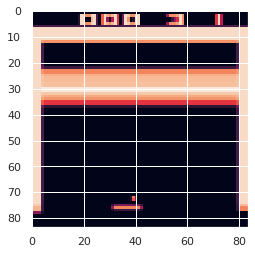

TARGET D1:


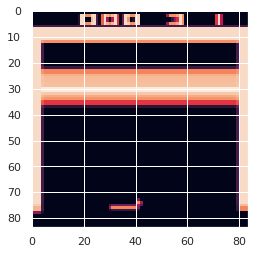

PRED D1:


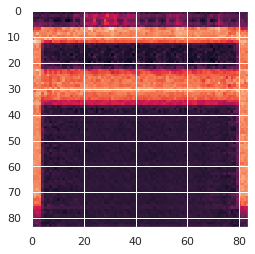

TARGET D2:


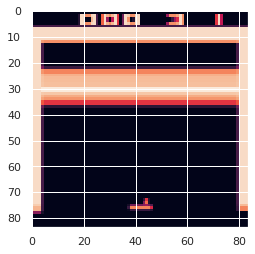

PRED D2:


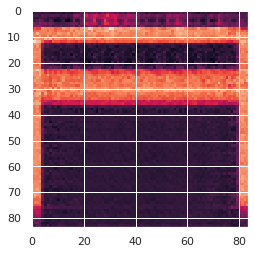

Batch 1, loss_ae_1 0.003743724664673209, loss_ae_2 0.004387033637613058
Batch 2, loss_ae_1 0.0034058813471347094, loss_ae_2 0.003931437153369188
Batch 3, loss_ae_1 0.003957074601203203, loss_ae_2 0.0045925104059278965
Batch 4, loss_ae_1 0.0029791698325425386, loss_ae_2 0.0035220866557210684
Batch 5, loss_ae_1 0.0031401480082422495, loss_ae_2 0.0038859923370182514
OBS:


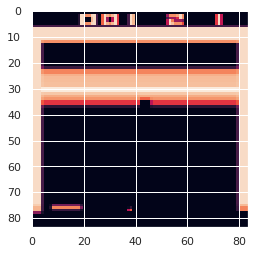

TARGET D1:


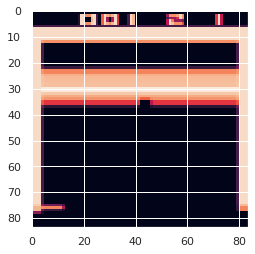

PRED D1:


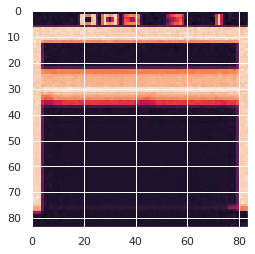

TARGET D2:


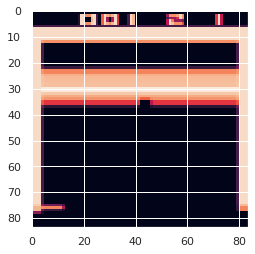

PRED D2:


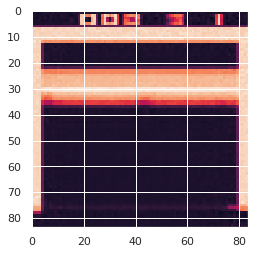

Batch 6, loss_ae_1 0.0029001329094171524, loss_ae_2 0.003592211054638028
Batch 7, loss_ae_1 0.0032896173652261496, loss_ae_2 0.004506977275013924
Batch 8, loss_ae_1 0.0026705770287662745, loss_ae_2 0.0037979544140398502
Batch 9, loss_ae_1 0.0028603258542716503, loss_ae_2 0.004013129975646734
Batch 10, loss_ae_1 0.00266216485761106, loss_ae_2 0.0037157884798943996
OBS:


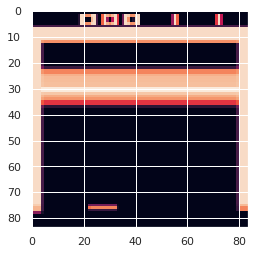

TARGET D1:


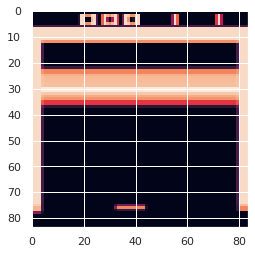

PRED D1:


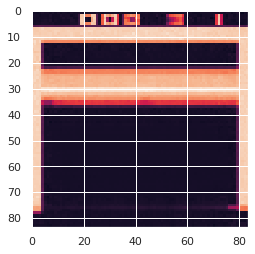

TARGET D2:


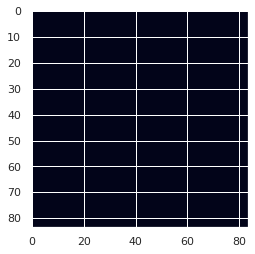

PRED D2:


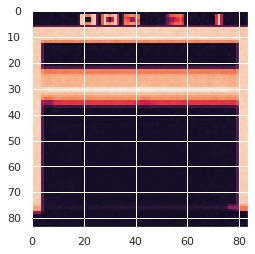

Batch 11, loss_ae_1 0.0027733060996979475, loss_ae_2 0.004012752790004015
Batch 12, loss_ae_1 0.002649021102115512, loss_ae_2 0.0036985210608690977
Batch 13, loss_ae_1 0.0026620104908943176, loss_ae_2 0.0036759439390152693
Batch 14, loss_ae_1 0.002948271343484521, loss_ae_2 0.004195593297481537
Batch 15, loss_ae_1 0.0026953378692269325, loss_ae_2 0.003832815680652857
OBS:


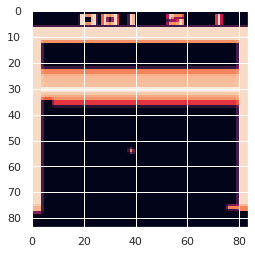

TARGET D1:


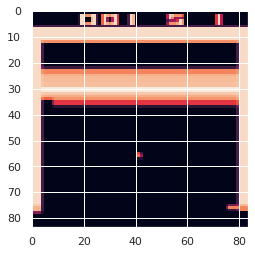

PRED D1:


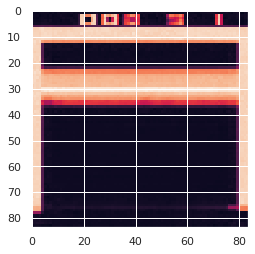

TARGET D2:


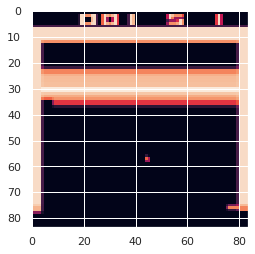

PRED D2:


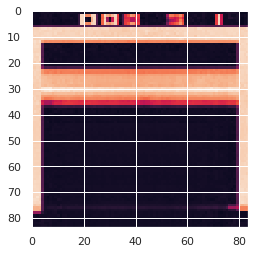

Batch 16, loss_ae_1 0.0026274393312633038, loss_ae_2 0.0036667485255748034
Batch 17, loss_ae_1 0.002829798962920904, loss_ae_2 0.004010837059468031
Batch 18, loss_ae_1 0.0031374366953969, loss_ae_2 0.004223024006932974
Batch 19, loss_ae_1 0.002867854665964842, loss_ae_2 0.0039046809542924166
Batch 20, loss_ae_1 0.0025977143086493015, loss_ae_2 0.0034109260886907578
OBS:


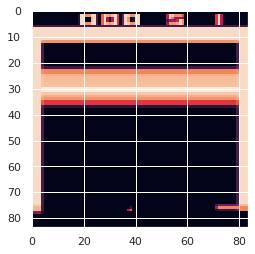

TARGET D1:


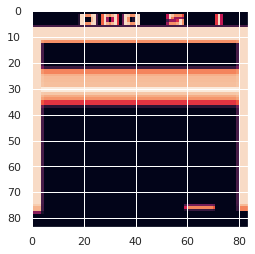

PRED D1:


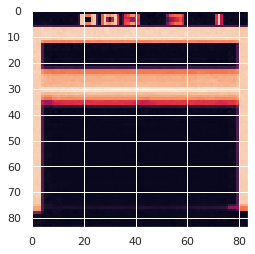

TARGET D2:


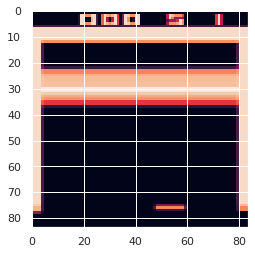

PRED D2:


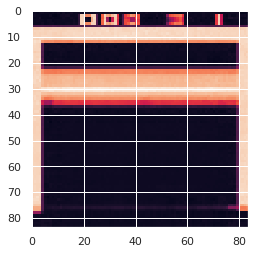

Batch 21, loss_ae_1 0.0025597766507416964, loss_ae_2 0.00330891995690763
Batch 22, loss_ae_1 0.002273149788379669, loss_ae_2 0.0029354437720030546
Batch 23, loss_ae_1 0.0023690853267908096, loss_ae_2 0.003039032919332385
Batch 24, loss_ae_1 0.0024488233029842377, loss_ae_2 0.00324161141179502
Batch 25, loss_ae_1 0.00239422544836998, loss_ae_2 0.0030163773335516453
OBS:


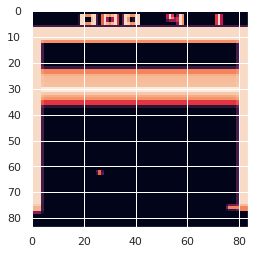

TARGET D1:


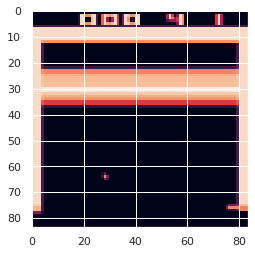

PRED D1:


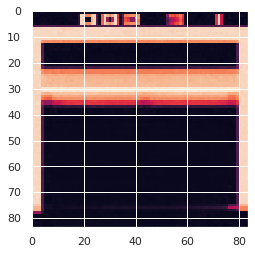

TARGET D2:


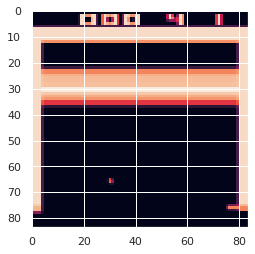

PRED D2:


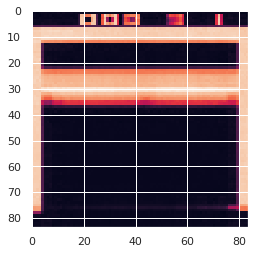

Batch 26, loss_ae_1 0.002703580306842923, loss_ae_2 0.0045926873572170734
Batch 27, loss_ae_1 0.002331353956833482, loss_ae_2 0.002826306503266096
Batch 28, loss_ae_1 0.0025649333838373423, loss_ae_2 0.003021589480340481
Batch 29, loss_ae_1 0.002364340703934431, loss_ae_2 0.0027576498687267303
Batch 30, loss_ae_1 0.002392733469605446, loss_ae_2 0.0027469415217638016
OBS:


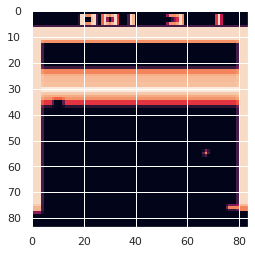

TARGET D1:


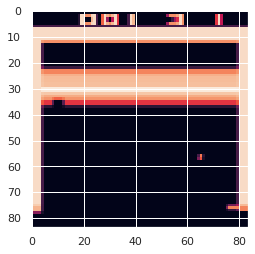

PRED D1:


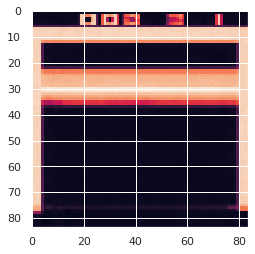

TARGET D2:


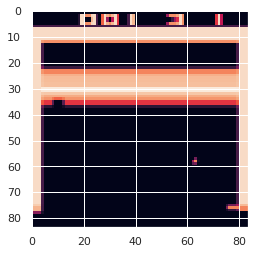

PRED D2:


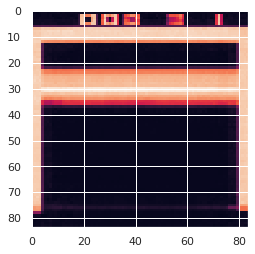

Batch 31, loss_ae_1 0.0021376176737248898, loss_ae_2 0.0025006961077451706
Batch 32, loss_ae_1 0.0027197408489882946, loss_ae_2 0.0028075184673070908
Batch 33, loss_ae_1 0.002250470919534564, loss_ae_2 0.0022689581383019686
Batch 34, loss_ae_1 0.002375710057094693, loss_ae_2 0.0025846934877336025
Batch 35, loss_ae_1 0.0023678045254200697, loss_ae_2 0.0023636932019144297
OBS:


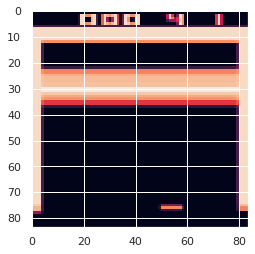

TARGET D1:


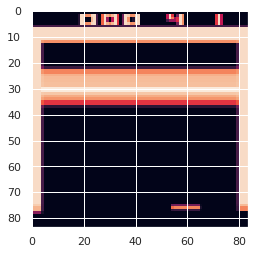

PRED D1:


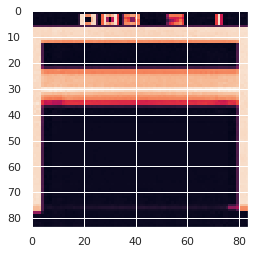

TARGET D2:


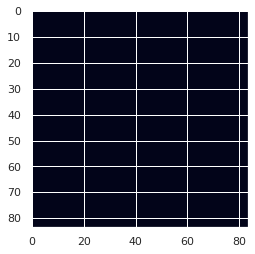

PRED D2:


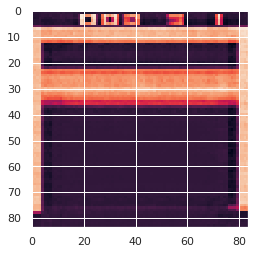

Batch 36, loss_ae_1 0.002334925811737776, loss_ae_2 0.002256496576592326
Batch 37, loss_ae_1 0.0021678765770047903, loss_ae_2 0.002147295279428363
Batch 38, loss_ae_1 0.0028967494145035744, loss_ae_2 0.0025925817899405956
Batch 39, loss_ae_1 0.0022196404170244932, loss_ae_2 0.0019519601482897997
Batch 40, loss_ae_1 0.0020865355618298054, loss_ae_2 0.001801873673684895
OBS:


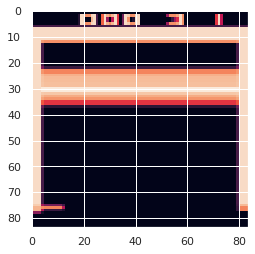

TARGET D1:


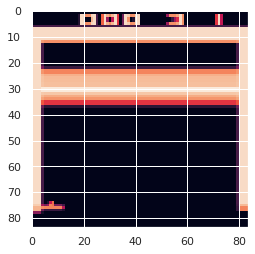

PRED D1:


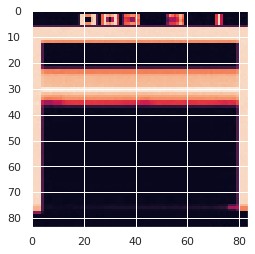

TARGET D2:


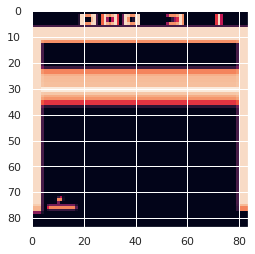

PRED D2:


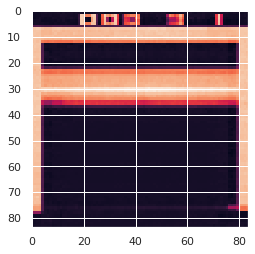

Batch 41, loss_ae_1 0.002229521982371807, loss_ae_2 0.0019067989196628332
Batch 42, loss_ae_1 0.002418918302282691, loss_ae_2 0.001739569241181016
Batch 43, loss_ae_1 0.002485003089532256, loss_ae_2 0.0018345618154853582
Batch 44, loss_ae_1 0.002669862238690257, loss_ae_2 0.0019425632199272513
Batch 45, loss_ae_1 0.0024655114393681288, loss_ae_2 0.0016490684356540442
OBS:


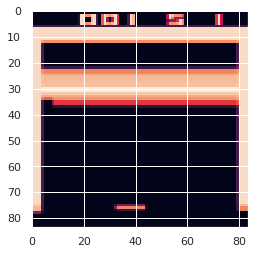

TARGET D1:


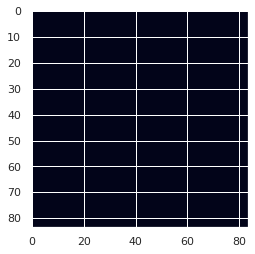

PRED D1:


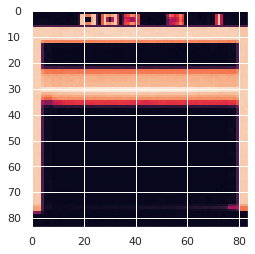

TARGET D2:


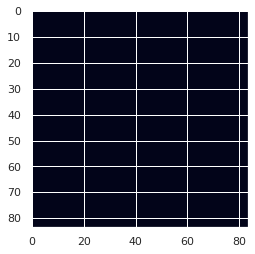

PRED D2:


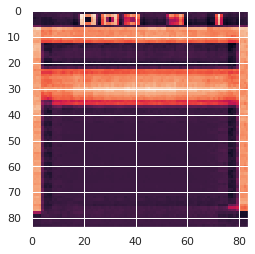

Batch 46, loss_ae_1 0.002268986776471138, loss_ae_2 0.0016521092038601637
Batch 47, loss_ae_1 0.0024466996546834707, loss_ae_2 0.001711984514258802
Batch 48, loss_ae_1 0.0025272651109844446, loss_ae_2 0.0015780831454321742
Batch 49, loss_ae_1 0.0025653194170445204, loss_ae_2 0.0016669335309416056
Batch 50, loss_ae_1 0.002173816552385688, loss_ae_2 0.001473662443459034
OBS:


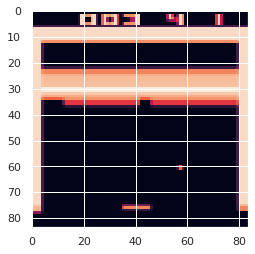

TARGET D1:


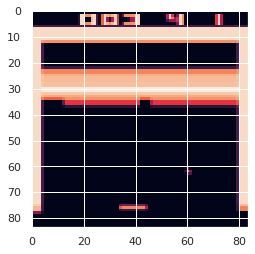

PRED D1:


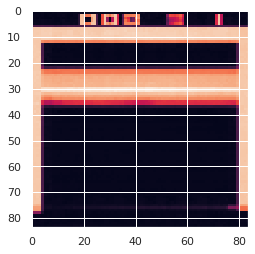

TARGET D2:


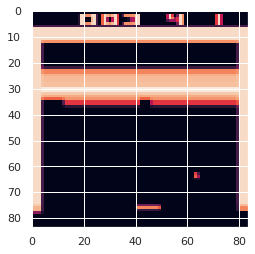

PRED D2:


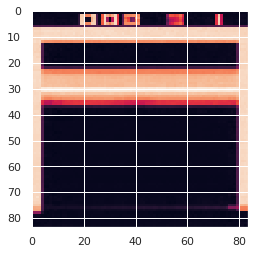

Batch 51, loss_ae_1 0.0024158700834959745, loss_ae_2 0.0016395746497437358
Batch 52, loss_ae_1 0.0021646751556545496, loss_ae_2 0.0013594821793958545
Batch 53, loss_ae_1 0.0022504571825265884, loss_ae_2 0.001455320161767304
Batch 54, loss_ae_1 0.0023342864587903023, loss_ae_2 0.0015734269982203841
Batch 55, loss_ae_1 0.0020959374960511923, loss_ae_2 0.0015109967207536101
OBS:


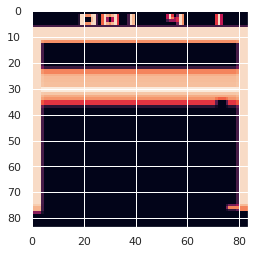

TARGET D1:


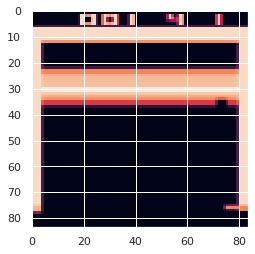

PRED D1:


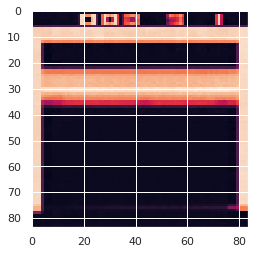

TARGET D2:


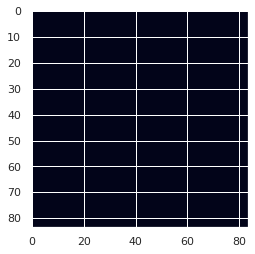

PRED D2:


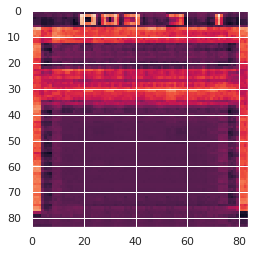

Batch 56, loss_ae_1 0.0021213525906205177, loss_ae_2 0.0014370960416272283
Batch 57, loss_ae_1 0.0021974309347569942, loss_ae_2 0.0015256053302437067
Batch 58, loss_ae_1 0.0021703660022467375, loss_ae_2 0.001344645512290299
Batch 59, loss_ae_1 0.0023189091589301825, loss_ae_2 0.0012799458345398307
Batch 60, loss_ae_1 0.0020224465988576412, loss_ae_2 0.0012982694897800684
OBS:


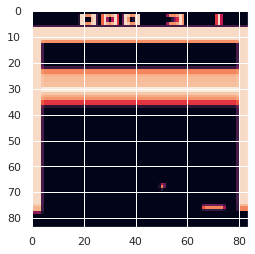

TARGET D1:


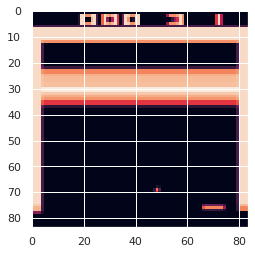

PRED D1:


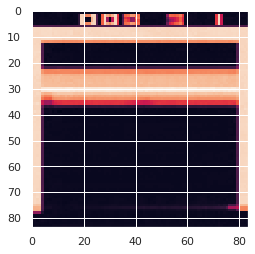

TARGET D2:


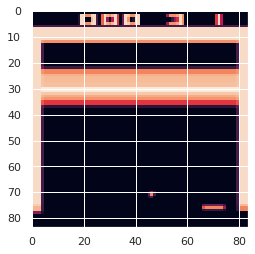

PRED D2:


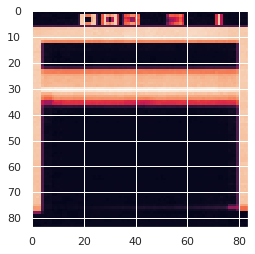

Batch 61, loss_ae_1 0.002344223205000162, loss_ae_2 0.0014281005132943392
Batch 62, loss_ae_1 0.002492266008630395, loss_ae_2 0.0013913409784436226
Batch 63, loss_ae_1 0.0022841200698167086, loss_ae_2 0.0012846642639487982
Batch 64, loss_ae_1 0.0021840690169483423, loss_ae_2 0.001208844711072743
Batch 65, loss_ae_1 0.0020091752521693707, loss_ae_2 0.0012618708424270153
OBS:


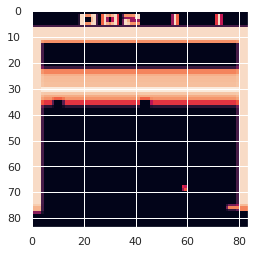

TARGET D1:


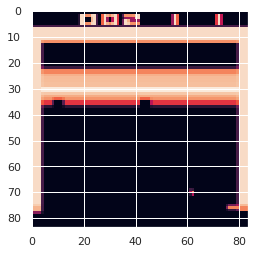

PRED D1:


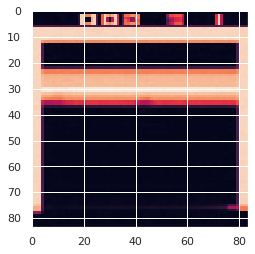

TARGET D2:


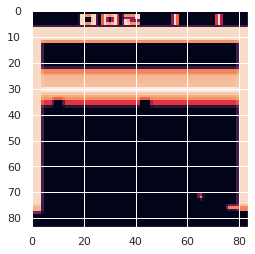

PRED D2:


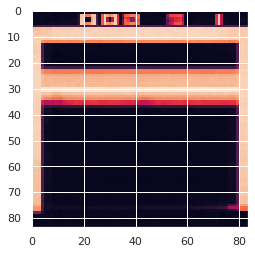

Batch 66, loss_ae_1 0.002236578380689025, loss_ae_2 0.001268496154807508
Batch 67, loss_ae_1 0.0019155105110257864, loss_ae_2 0.0013153314357623458
Batch 68, loss_ae_1 0.002005020622164011, loss_ae_2 0.0012943067122250795
Batch 69, loss_ae_1 0.002070001093670726, loss_ae_2 0.001315633999183774
Batch 70, loss_ae_1 0.0019283932633697987, loss_ae_2 0.001276884344406426
OBS:


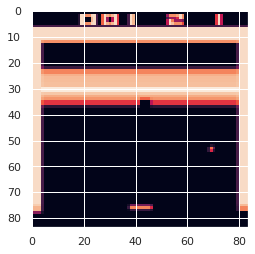

TARGET D1:


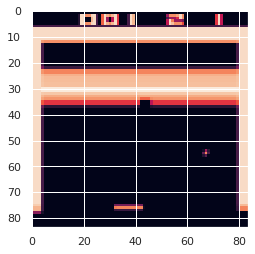

PRED D1:


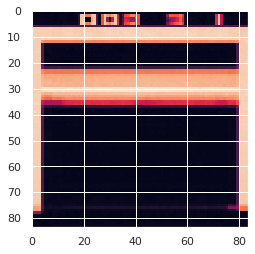

TARGET D2:


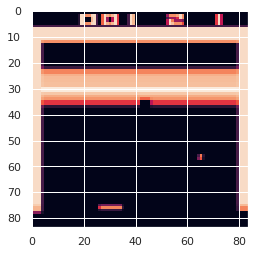

PRED D2:


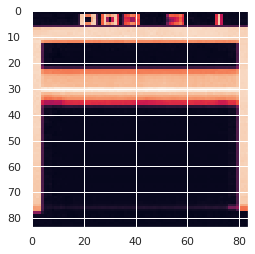

Batch 71, loss_ae_1 0.0020372860599309206, loss_ae_2 0.001220049220137298
Batch 72, loss_ae_1 0.001994258724153042, loss_ae_2 0.0011858029756695032
Batch 73, loss_ae_1 0.0019685341976583004, loss_ae_2 0.0011924999998882413
Batch 74, loss_ae_1 0.00194978853687644, loss_ae_2 0.0013309384230524302
Batch 75, loss_ae_1 0.0019018116872757673, loss_ae_2 0.0013963909586891532
OBS:


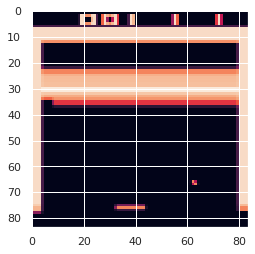

TARGET D1:


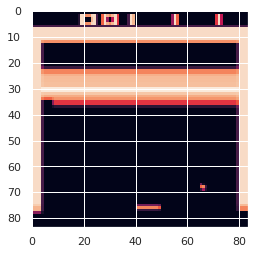

PRED D1:


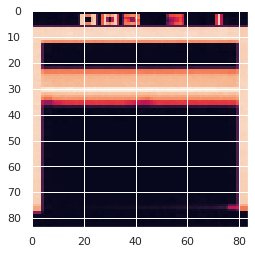

TARGET D2:


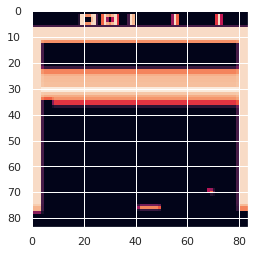

PRED D2:


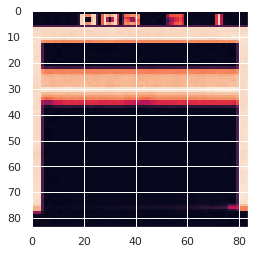

Batch 76, loss_ae_1 0.0018020387506112456, loss_ae_2 0.001175199169665575
Batch 77, loss_ae_1 0.0017104771686717868, loss_ae_2 0.0011618882417678833
Batch 78, loss_ae_1 0.0019510998390614986, loss_ae_2 0.0010844174539670348
Batch 79, loss_ae_1 0.001875331741757691, loss_ae_2 0.0013394395355135202
Batch 80, loss_ae_1 0.0019990429282188416, loss_ae_2 0.0014699054881930351
OBS:


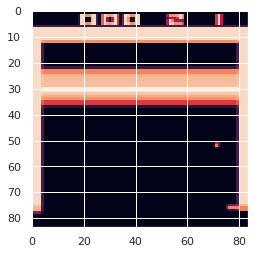

TARGET D1:


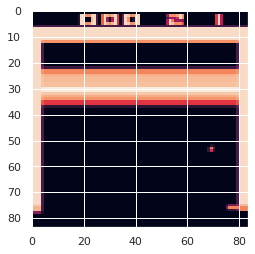

PRED D1:


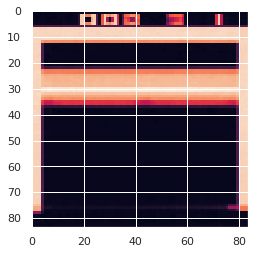

TARGET D2:


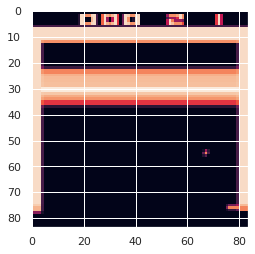

PRED D2:


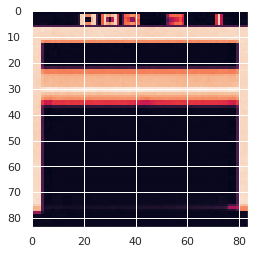

Batch 81, loss_ae_1 0.002035431331023574, loss_ae_2 0.0013554042670875788
Batch 82, loss_ae_1 0.002309250645339489, loss_ae_2 0.0016107602277770638
Batch 83, loss_ae_1 0.0015584283974021673, loss_ae_2 0.0009922788012772799
Batch 84, loss_ae_1 0.0018386561423540115, loss_ae_2 0.0012980601750314236
Batch 85, loss_ae_1 0.002099759643897414, loss_ae_2 0.0014182081213220954
OBS:


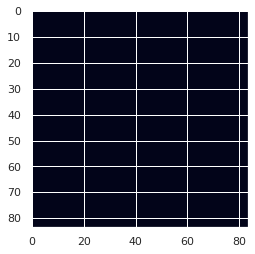

TARGET D1:


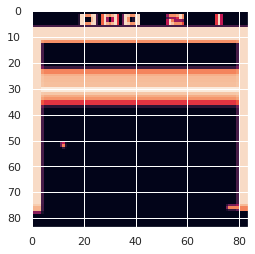

PRED D1:


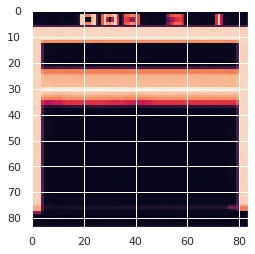

TARGET D2:


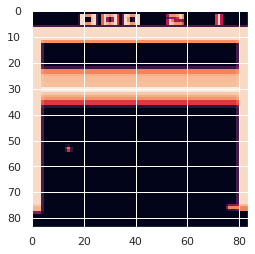

PRED D2:


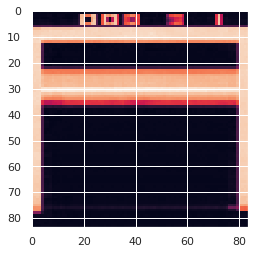

Batch 86, loss_ae_1 0.0018252227455377579, loss_ae_2 0.00120064546354115
Batch 87, loss_ae_1 0.0020806228276342154, loss_ae_2 0.001740831765346229
Batch 88, loss_ae_1 0.001727233175188303, loss_ae_2 0.001520691905170679
Batch 89, loss_ae_1 0.0016722503351047635, loss_ae_2 0.0013998998329043388
Batch 90, loss_ae_1 0.001685442286543548, loss_ae_2 0.001217002747580409
OBS:


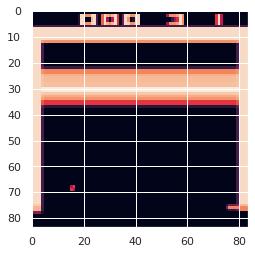

TARGET D1:


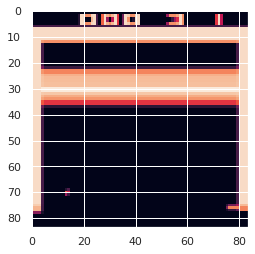

PRED D1:


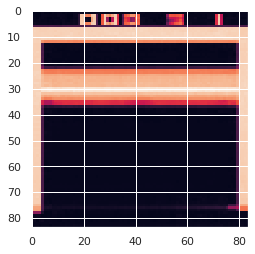

TARGET D2:


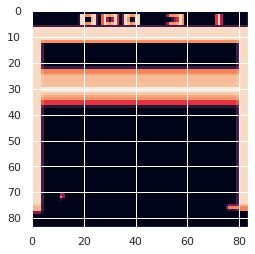

PRED D2:


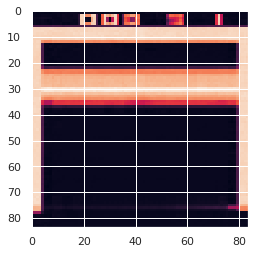

Batch 91, loss_ae_1 0.0015377877280116081, loss_ae_2 0.0012259441427886486
Batch 92, loss_ae_1 0.001857115188613534, loss_ae_2 0.0012581415940076113
Batch 93, loss_ae_1 0.0018729319563135505, loss_ae_2 0.0015418592374771833
Batch 94, loss_ae_1 0.0011701856274157763, loss_ae_2 0.0011598644778132439
Batch 95, loss_ae_1 0.0013732817023992538, loss_ae_2 0.0012015060056000948
OBS:


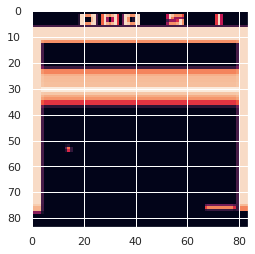

TARGET D1:


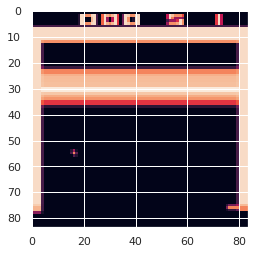

PRED D1:


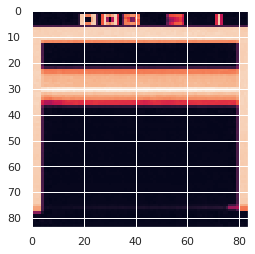

TARGET D2:


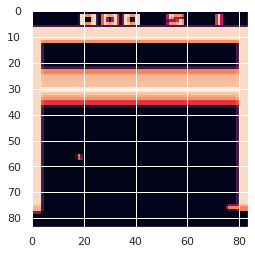

PRED D2:


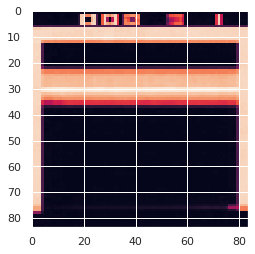

KeyboardInterrupt: ignored

In [23]:
FR = ROLLOUT_LENGTH*NENV

loss_history_ae_1 = []
loss_history_ae_2 = []
frames_loss_history_ae_1 = []
frames_loss_history_ae_2 = []

# Testing AE / pretraining
for ii in range(NUM_UPDATES):
    obs, obs_d1, obs_d2, logps, actions, values, rewards, infos = next(rgen)
    for jj in range(100):
        pred_ae_1, z1 = ae_delta_1(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_1 = citerion(pred_ae_1, obs_d1)
        ae_optim_1.zero_grad()
        loss_ae_1.backward()
        nn.utils.clip_grad_norm_(ae_delta_1.parameters(), 0.5)
        ae_optim_1.step()

        pred_ae_2, z2 = ae_delta_2(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_2 = citerion(pred_ae_2, obs_d2)
        ae_optim_2.zero_grad()
        loss_ae_2.backward()
        nn.utils.clip_grad_norm_(ae_delta_2.parameters(), 0.5)
        ae_optim_2.step()

        frames = (ii*100*FR) + (jj*FR)
        loss_history_ae_1.append(loss_ae_1.item())
        frames_loss_history_ae_1.append((frames, loss_ae_1.item()))
        loss_history_ae_2.append(loss_ae_2.item())
        frames_loss_history_ae_2.append((frames, loss_ae_2.item()))
        
    print(f'Batch {ii}, loss_ae_1 {loss_ae_1}, loss_ae_2 {loss_ae_2}')
    ae_1_scheduler.step(ii)
    ae_2_scheduler.step(ii)

    if ii % 5 == 0:
        print('OBS:')
        plt.imshow(obs.cpu().numpy()[500][0])
        plt.show()
        print('TARGET D1:')
        plt.imshow(obs_d1.cpu().numpy()[500][0])
        plt.show()
        print('PRED D1:')
        plt.imshow(pred_ae_1.detach().cpu().numpy()[500][0])
        plt.show()
        print('TARGET D2:')
        plt.imshow(obs_d2.cpu().numpy()[500][0])
        plt.show()
        print('PRED D2:')
        plt.imshow(pred_ae_2.detach().cpu().numpy()[500][0])
        plt.show()

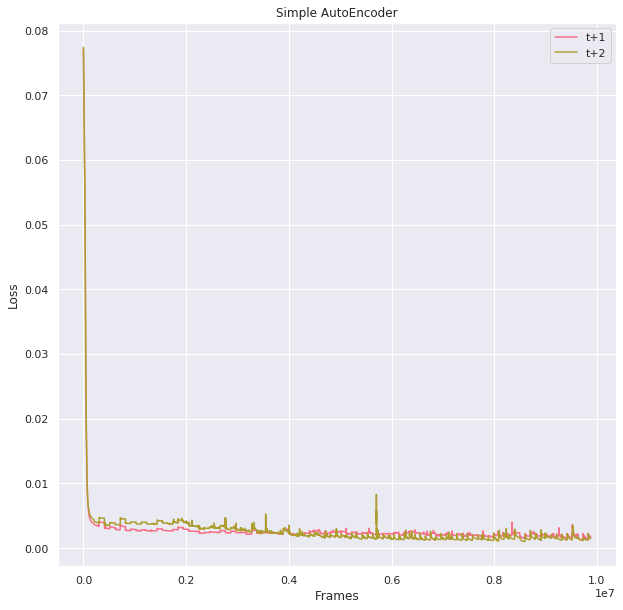

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Frames')
ax.set_ylabel('Loss')
ax.set_title('Simple AutoEncoder')
clrs = sns.color_palette("husl", 5)

ax.plot(
    *zip(*frames_loss_history_ae_1),
    label='t+1', 
    c=clrs[0]
)
ax.plot(
    *zip(*frames_loss_history_ae_2),
    label='t+2', 
    c=clrs[1]
)

ax.legend(loc='upper right')